# Autoencoders

In this notebook, I borrow heavily from [the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html). So rather than sprinkling references to the Keras blog throughout the notebook, just assume I stole it from [Francois Chollet](https://twitter.com/fchollet). Because open source or something.

![stole from Keras blog](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

So, autoencoders. They're legit. They do perform data compression but not in the JPEG or MPEG way -- these fellas make some broad assumptions about images, sound, and video and apply compression based on the assumptions.

Autoencoders **learn** (automatically) a lossy compression based on the data examples fed in. So the compression is specific to those examples.

## What's Required

Autoencoders require 3 things:

1. Encoding function
2. Decoding function
3. Loss function describing the amount of information loss between the compressed and decompressed representations of the data examples and the decompressed representation (i.e. a "loss" function).

The encoding/decoding functions are typically (parametric) neural nets and are differentiable with respect to the distance function. The differentiable part enables optimizing the parameters of the encoding/decoding functions to minimize the reconstruction loss.

## What Are They Good For

1. Data Denoising
2. Dimension Reduction
3. Data Visualization (basically the same as 2, but plots)

For data denoising, think PCA, but nonlinear. In fact, if the encoder/decoder functions are linear, the result spans the space of the PCA solution. The nonlinear part is useful because they can capture, for example, multimodality in the feature space, which PCA can't.

Dimension reduction is a direct result of the lossy compression of the algorithm. It can help with denoising and **pre-training** before building another ML algorithm. But is the compression good enough to replace JPEG or MPEG? Nope. And probably not anytime soon. But maybe one day.

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential  # TODO: Rm Sequential?
from keras.layers import Input, Dense
from keras import regularizers

Using TensorFlow backend.


# Data Loading and Preprocessing

In [2]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

In [4]:
# 60K training 28 x 28 (pixel) images
x_train.shape

(60000, 28, 28)

In [5]:
# 10K test 28 x 28 (pixel) images
x_test.shape

(10000, 28, 28)

In [6]:
# Reshapes 28 x 28 images into vectors of length 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

In [7]:
input_dim = x_train.shape[1]

# Simple Autoencoder

A single fully-connected neural layer as an encoder function and an decoder function.

In [8]:
# Size of our encoded representations
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

# Input placeholder
input_img = Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Compression factor: 24.5


## Encoder Model

In [9]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## Decoder Model

In [10]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [11]:
# Trains the model, iterating on the training data in batches of 256 in 50 epochs.
# Using the Adam optimizer and per-pixel binary crossentropy loss.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s - loss: 0.2745 - val_loss: 0.1855
Epoch 2/50
60000/60000 [==============================] - 7s - loss: 0.1696 - val_loss: 0.1547
Epoch 3/50
60000/60000 [==============================] - 6s - loss: 0.1453 - val_loss: 0.1345
Epoch 4/50
60000/60000 [==============================] - 7s - loss: 0.1289 - val_loss: 0.1214
Epoch 5/50
60000/60000 [==============================] - 6s - loss: 0.1182 - val_loss: 0.1130
Epoch 6/50
60000/60000 [==============================] - 7s - loss: 0.1110 - val_loss: 0.1069
Epoch 7/50
60000/60000 [==============================] - 7s - loss: 0.1057 - val_loss: 0.1023
Epoch 8/50
60000/60000 [==============================] - 7s - loss: 0.1018 - val_loss: 0.0991
Epoch 9/50
60000/60000 [==============================] - 6s - loss: 0.0991 - val_loss: 0.0969
Epoch 10/50
60000/60000 [==============================] - 6s - loss: 0.0973 - val_loss: 0.0954

In [12]:
# encode and decode some digits from the test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

encoded_imgs.mean()

8.70998

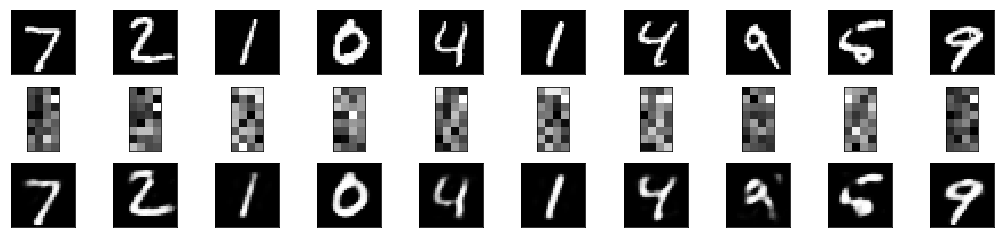

In [13]:
# Number of digits to display
n = 10  
plt.figure(figsize=(18, 4))

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, n, n + i + 1)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, n, 2*n + i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Deep Autoencoder

Instead of limiting ourselves to a single fully-connected neural layer, we can stack multiple layers in the encoder and decoder functions.

The reconstructed digits look much better than those from the single-layer autoencoder.

In [44]:
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

input_img = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

Compression factor: 24.5


## Encoder Model

In [45]:
# Maps an input image to its encoded representation
encoder = Model(input_img, encoded)

## Decoder Model

In [46]:
# create a placeholder for an encoded (32-dimensional) input
decoded_input = Input(shape=(encoding_dim,))

# retrieve the last 3 layers of the autoencoder model to get the decoder layers
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
decoder_layers = decoder_layer3(decoder_layer2(decoder_layer1(encoded_input)))

# create the decoder model
decoder = Model(encoded_input, decoder_layers)

In [47]:
# Trains the model, iterating on the training data in batches of 256 in 50 epochs.
# Using the Adam optimizer and per-pixel binary crossentropy loss.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s - loss: 0.2419 - val_loss: 0.1688
Epoch 2/50
60000/60000 [==============================] - 9s - loss: 0.1521 - val_loss: 0.1387
Epoch 3/50
60000/60000 [==============================] - 10s - loss: 0.1344 - val_loss: 0.1287
Epoch 4/50
60000/60000 [==============================] - 10s - loss: 0.1254 - val_loss: 0.1198
Epoch 5/50
60000/60000 [==============================] - 10s - loss: 0.1187 - val_loss: 0.1147
Epoch 6/50
60000/60000 [==============================] - 10s - loss: 0.1139 - val_loss: 0.1103
Epoch 7/50
60000/60000 [==============================] - 10s - loss: 0.1104 - val_loss: 0.1077
Epoch 8/50
60000/60000 [==============================] - 10s - loss: 0.1081 - val_loss: 0.1057
Epoch 9/50
60000/60000 [==============================] - 10s - loss: 0.1059 - val_loss: 0.1038
Epoch 10/50
60000/60000 [==============================] - 10s - loss: 0.1041 - val_los

In [76]:
# encode and decode some digits from the test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [77]:
encoded_imgs.mean()

16.699591

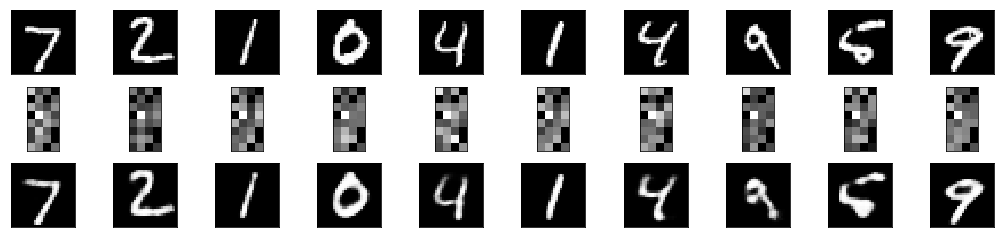

In [75]:
# Number of digits to display
n = 10  
plt.figure(figsize=(18, 4))

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, n, n + i + 1)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, n, 2*n + i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()